In [1]:
# load sample images using scikit learn 


In [2]:
import numpy as np
import torch 
from sklearn.datasets import load_sample_images
import matplotlib.pyplot as plt
import torchvision
import torchvision.transforms.v2 as T
import torch.nn as nn
import torch.nn.functional as F
from functools import partial
from pathlib import Path
from torch.utils.data import DataLoader , TensorDataset
import torchmetrics

In [3]:
images = load_sample_images()['images']

In [4]:
images[0].shape

(427, 640, 3)

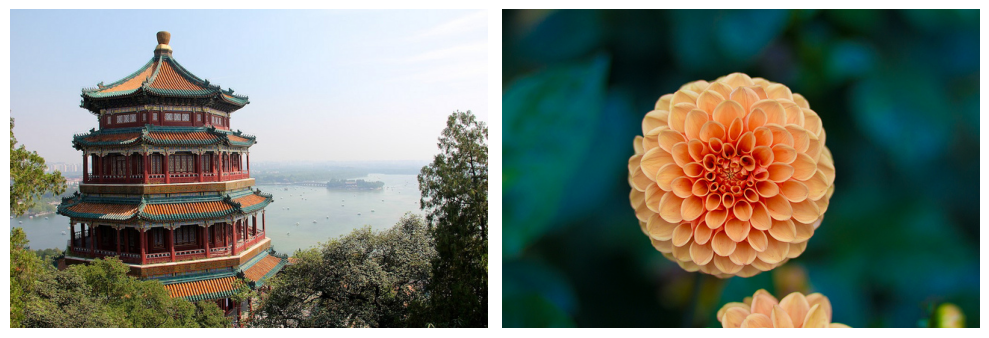

In [5]:
fig , axis = plt.subplots(nrows = 1 , ncols = 2 , figsize=(10 , 10))
plt.sca(axis[0])
plt.imshow(images[0])
plt.axis('off')
plt.sca(axis[1])
plt.imshow(images[1])
plt.axis('off')
plt.tight_layout()
plt.show()


In [6]:
# lets stack these iamges 

sample_images = np.stack(images)

#lets conver to tenosr

In [7]:
sample_images = torch.tensor(sample_images , dtype=torch.float32) / 255

# divided by 255 to normalize the rgb values

In [8]:
sample_images.shape

# 2 batch images , height , width and channel

torch.Size([2, 427, 640, 3])

In [9]:
# pytorch excepts channle dimensions to be before height and width not after so lets change 

In [10]:
sample_images_permuted = sample_images.permute(0 , 3 , 1 ,2)
sample_images_permuted.shape

#batch size , channel , height , width

torch.Size([2, 3, 427, 640])

In [11]:
# center crop the images which means to cut the edges of the imaegs 
# it assumes that the most detail is present at the center

In [12]:
cropped_images = T.CenterCrop((70 , 120))(sample_images_permuted)
cropped_images.shape

torch.Size([2, 3, 70, 120])

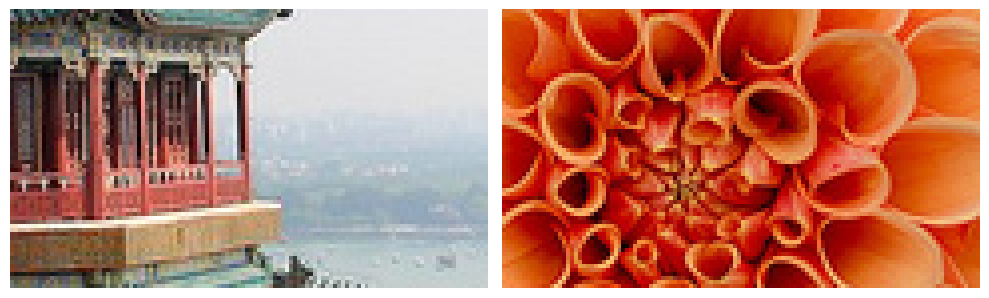

In [13]:
#see 
fig , ax = plt.subplots(1 , 2 , figsize=(10 ,10))
for i in range(2):
    img_to_show = cropped_images[i]
    img_to_show_permute = img_to_show.permute(1 , 2 , 0).numpy()
    ax[i].imshow(img_to_show_permute)
    ax[i].set_axis_off()
   
plt.tight_layout()
plt.show()  
    


In [14]:
#create 2d convolution layer 

In [15]:
torch.manual_seed(42)
conv_layer = nn.Conv2d(in_channels=3 , out_channels=32 , kernel_size=7)
fmaps = conv_layer(cropped_images)

# in channels = rgb , looking for 32 different patterns and each neurons looks at 7x7 filed 

In [16]:
# pixel lost on edges due to no padding also called valid padding or padding = 0 default

fmaps.shape

torch.Size([2, 32, 64, 114])

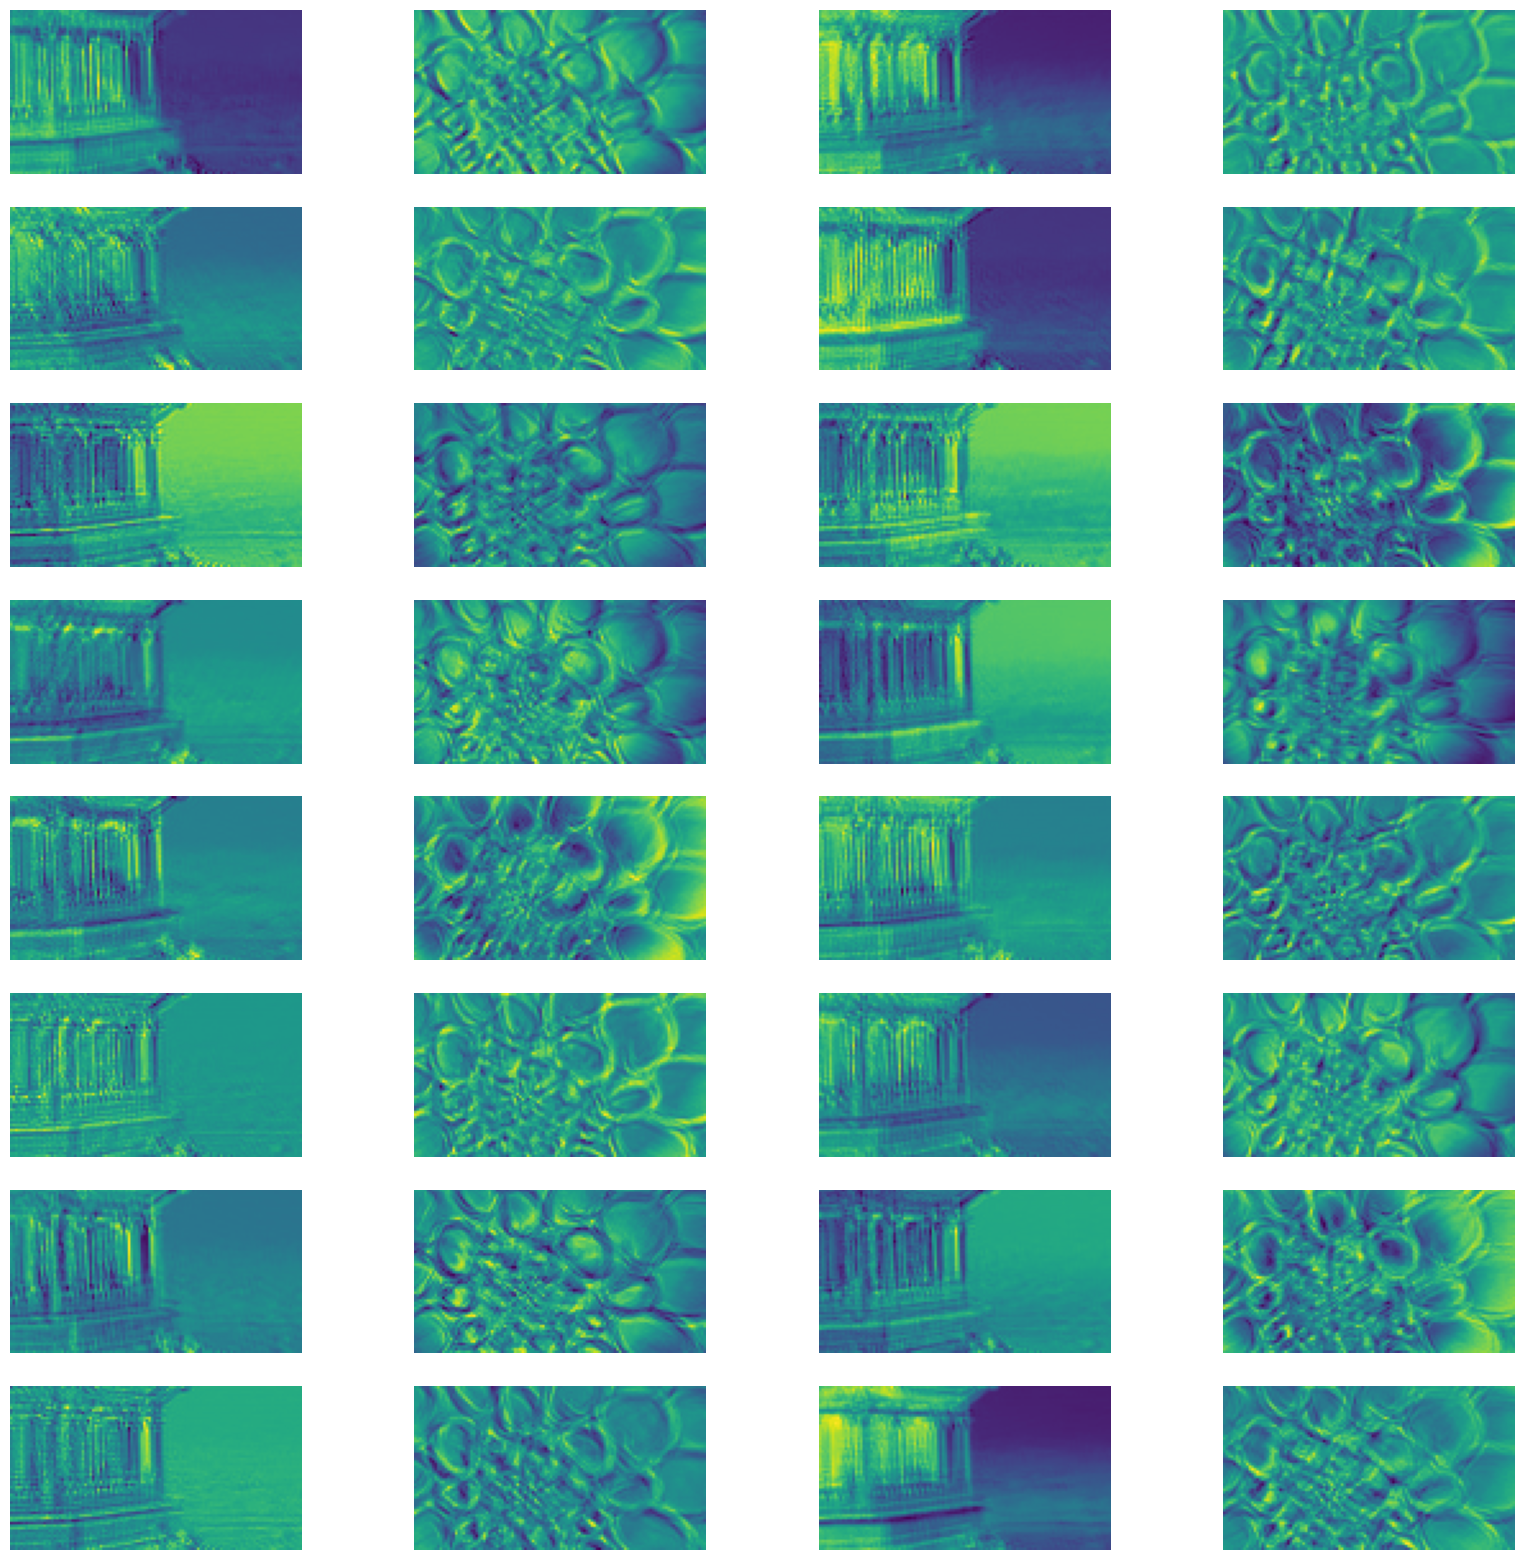

In [17]:
#see 
fig , ax = plt.subplots(8 , 4 , figsize=(20 ,20))

i=0
j=0
k=0
count = 0
while i<32 and j<8:
    index_image = 0 if i%2==0 else 1
    fmaps_show = fmaps[index_image].detach().permute(1 , 2, 0).numpy()
    ax[ j , k].imshow(fmaps_show[: , : , i])
    ax[ j , k].set_axis_off()
    count+=1
    k+=1
    
    if k == 4:
        k = 0
        
    if count == 4:
        j +=1
        count=0
    
    i+=1
   
    
    

plt.show()  
    



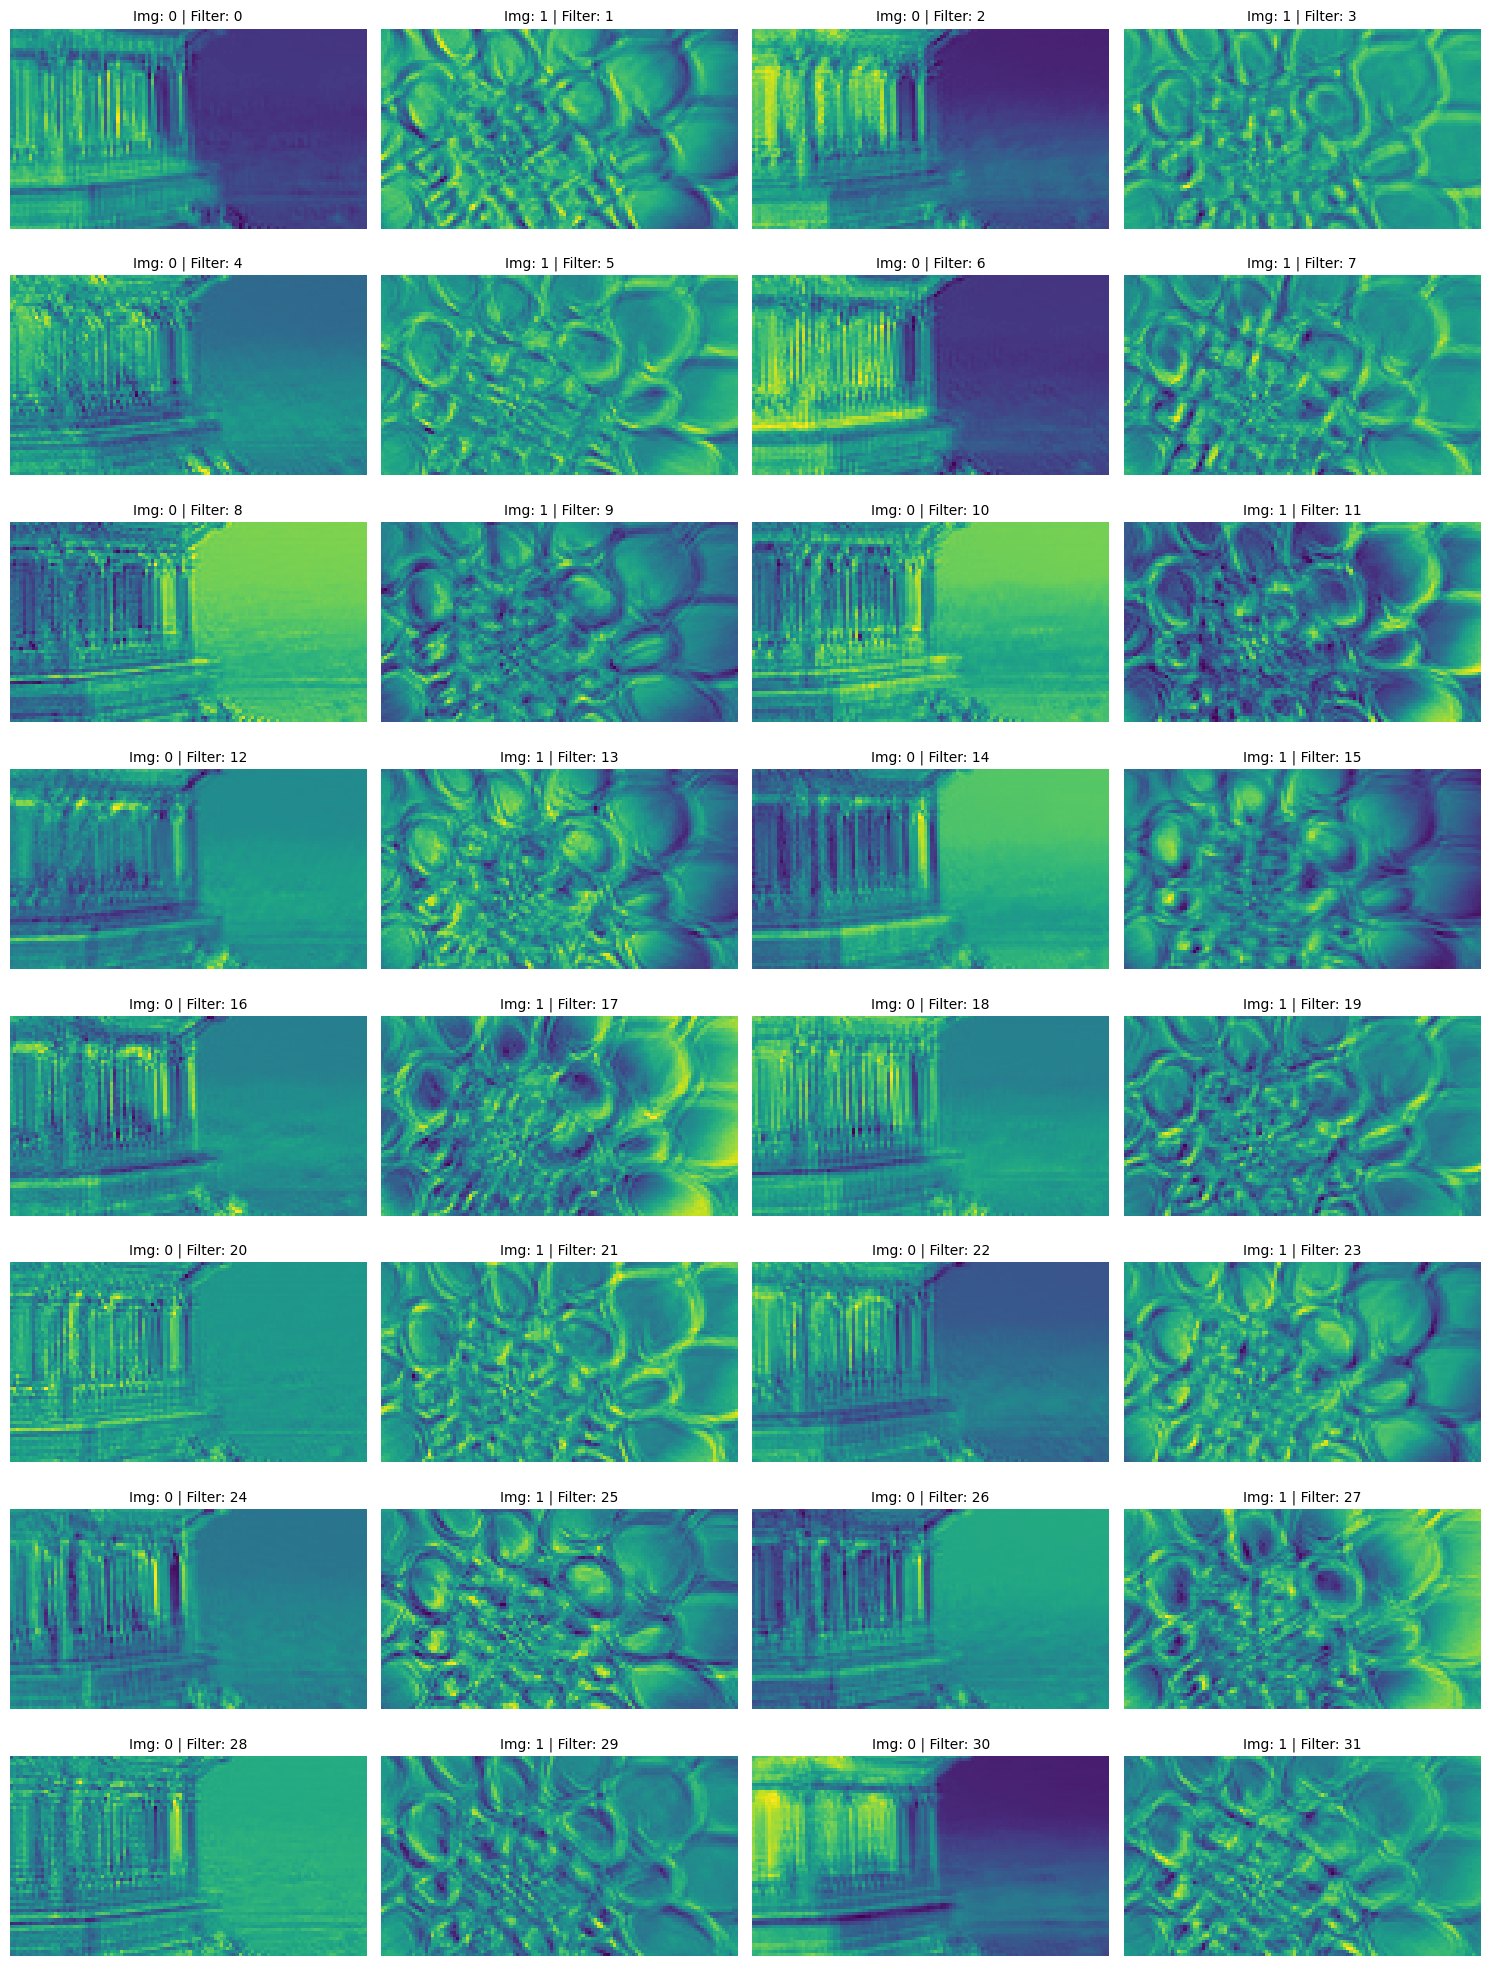

In [18]:
# A figsize of 100 is massive; 12-20 is usually perfect for screen viewing
fig, ax = plt.subplots(8, 4, figsize=(15, 20)) 

# .flat lets us iterate through the 8x4 grid as a single list of 32 spots
for i, axis in enumerate(ax.flat):
    # Alternate between image 0 and image 1 in the batch
    index_image = 0 if i % 2 == 0 else 1
    
    # Move to CPU, detach, and get the specific channel 'i'
    # We don't need to permute the whole thing if we just want one channel!
    # fmaps shape: [Batch, Channel, Height, Width]
    fmap_channel = fmaps[index_image, i].detach().cpu().numpy()
    
    axis.imshow(fmap_channel, cmap='viridis')
    axis.set_title(f"Img: {index_image} | Filter: {i}", fontsize=10)
    axis.axis('off')

plt.tight_layout()
plt.show()

In [19]:
# padding = same ensures same ouput dimensions

In [20]:
conv_layer = nn.Conv2d(in_channels=3 , out_channels=32 , kernel_size=7 ,
                       padding='same')
fmaps = conv_layer(cropped_images)

In [21]:
fmaps.shape

torch.Size([2, 32, 70, 120])

In [22]:
# the weight and the bias parameter
print(f' weigth : {conv_layer.weight.shape} , bias : {conv_layer.bias.shape}')

 weigth : torch.Size([32, 3, 7, 7]) , bias : torch.Size([32])


In [23]:
# the pooling layer 

In [24]:
# we will make a max pooling layer 

In [25]:
max_pool = nn.MaxPool2d(kernel_size=2)

In [26]:
# average pooling layer 

avg_pool = nn.AvgPool2d(kernel_size=2)

In [27]:
# depth pooling layer

class DepthPool(torch.nn.Module):
    def __init__(self , kernel_size , stride=None , padding=0):
        super().__init__()
        self.kernel_size = kernel_size
        self.stride = stride if stride is not None else kernel_size
        self.padding = padding # default is valid padding 
        
    def forward(self , inputs):
        batch , channels , height , width = inputs.shape
        z = inputs.view(batch , channels , height * width)
        z = z.permute(0 , 2 , 1)
        z = F.max_pool1d(z , kernel_size=self.kernel_size , stride = self.stride , 
                         padding= self.padding)
        z = z.permute(0 , 2 ,1)
        
        return z.view(batch , -1 , height , width)      #un permutes


In [28]:
# global average pooling laer 

global_avg_pool = nn.AdaptiveAvgPool2d(output_size=1)
output = global_avg_pool(cropped_images)

In [29]:
# cnn architecture 

In [30]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(f' your device is {device}')

 your device is cuda


In [31]:
toTensor = T.Compose([T.ToImage() , T.ToDtype(torch.float32 , scale = True)])
current_dir = Path.cwd()
dataset_path = current_dir.parent / 'nn_using_pytorch/classifier_using_pytorch/datasets'

print(dataset_path)

train_and_valid = torchvision.datasets.FashionMNIST(root=dataset_path, train=True , 
                                                    transform=toTensor)
test_data = torchvision.datasets.FashionMNIST(root=dataset_path , train=False,
                                              transform=toTensor)

torch.manual_seed(42)
train_data , valid_data = torch.utils.data.random_split(
    train_and_valid , lengths= [ 55_000 , 5_000]
)

train_loader = DataLoader(train_data , batch_size = 128 , shuffle=True , pin_memory=True , num_workers=4)
val_loader = DataLoader(valid_data , batch_size = 128 , shuffle=True ,pin_memory=True , num_workers=4)
test_loader = DataLoader(test_data , batch_size=128 , shuffle=True,pin_memory=True , num_workers=4)

/home/ateeksh/mlrepos/machine_learning_practice/deep_learning/nn_using_pytorch/classifier_using_pytorch/datasets


In [32]:
def eval(model , metric , data_loader):
    metric.reset()
    with torch.no_grad():
        for x_batch , y_batch in data_loader:
            x_batch , y_batch = x_batch.to(device) , y_batch.to(device)
            y_pred = model(x_batch)
            
            metric.update(y_pred , y_batch)
            
    return metric.compute()
        


def train_eval(model ,optimizer,  criterion , metric , train_loader ,
               val_loader ,no_epoch):
    
    history = {'train_loss' : [] , 'train_accuracy' : [] , 'val_accuracy' : []}
    
    for epoch in range(no_epoch):
        metric.reset()
        total_loss = 0
        model.train()
        
        for x_batch , y_batch in train_loader:
            x_batch , y_batch = x_batch.to(device) , y_batch.to(device)
            y_pred = model(x_batch)
            
            loss = criterion(y_pred , y_batch)
            total_loss += loss.item()
            
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()
            
            metric.update(y_pred , y_batch)
        
        mean_loss = total_loss/len(train_loader)
        history['train_loss'].append(mean_loss)
        history['train_accuracy'].append(metric.compute().item())
        
        history['val_accuracy'].append(eval(model , metric , val_loader).item())
        
        print(f" Epoch : {epoch + 1}/{no_epoch} "
              f" Training Loss : {history['train_loss'][-1]:.4f} ",
              f" Training Accuracy : {history['train_accuracy'][-1]:.4f} ",
              f" Valid Accuracy : {history['val_accuracy'][-1]:.4f}")

    return history        

In [33]:
DefaultConv2d = partial(nn.Conv2d , kernel_size = 3 , padding="same")
model = nn.Sequential(
    DefaultConv2d(in_channels=1 , out_channels=64 , kernel_size=7) , nn.ReLU(),
    nn.MaxPool2d(kernel_size=2),
    DefaultConv2d(in_channels=64 , out_channels=128) , nn.ReLU(),
    DefaultConv2d(in_channels=128 , out_channels=128 ) , nn.ReLU() ,
    nn.MaxPool2d(kernel_size=2),
    DefaultConv2d(in_channels=128 , out_channels=256) , nn.ReLU(),
    DefaultConv2d(in_channels=256 , out_channels=256 ) , nn.ReLU(),
    nn.MaxPool2d(kernel_size=2),
    nn.Flatten(),
    nn.Linear(in_features=2304 , out_features=128) , nn.ReLU(),
    nn.Dropout(0.5),
    nn.Linear(in_features=128 , out_features=64) , nn.ReLU(),
    nn.Dropout(0.5),
    nn.Linear(in_features=64 , out_features=10),
    
).to(device)

In [34]:
#trainig 

optimizer = torch.optim.AdamW(model.parameters())
xentropy = nn.CrossEntropyLoss()
metric = torchmetrics.Accuracy(task='multiclass' , num_classes=10).to(device)



# _ = train_eval(model , optimizer , xentropy , metric ,
#            train_loader , val_loader , 20)



# Epoch : 20/20  Training Loss : 0.1487   Training Accuracy : 0.9483   Valid Accuracy : 0.9116

In [35]:
# test_accuracy = eval(model , metric , test_loader).item()
# print(f'The test accuracy is {test_accuracy:.4f}')

# The test accuracy is 0.9098

In [36]:
# CNN ARCHITECTURE

In [37]:
#googlenet 


In [38]:
#resnet